In [1]:
import os
import itertools
import random
import copy
import json

import numpy as np

from models import Discriminator, weights_init_normal, GeneratorResNet
from utils import ReplayBuffer, LambdaLR

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

from torch.utils.tensorboard import SummaryWriter

from easydict import EasyDict as edict

import torch
from torch.autograd import Variable
import torch.nn as nn

import sys
sys.path.append("../discogan")
from my_utils import load_dataset, LoaderSampler, tensor2img, get_Z_pushed_loader_stats
from fid_score import calculate_frechet_distance


batchsize = 1

opt = edict({
    "devices": [4],
    "epoch": 0,
    "n_epochs": 200,
    "decay_epoch": 100,
    
    "batch_size": batchsize,
    "lr": 0.0002,
    "b1": 0.5,
    "b2": 0.999,

    "n_residual_blocks": 9,
    "lambda_cyc": 10.0,
    "lambda_id": 5.0,

    "image_save_interval": (500 * 64) // batchsize,
    "model_save_interval": (500 * 64) // batchsize
})

In [2]:
DATASET1, DATASET1_PATH = 'outdoor', '../../../data/outdoor_128.hdf5'
DATASET2, DATASET2_PATH = 'church', '../../../data/church_128.hdf5'

IMG_SIZE = 128

filename = 'stats/{}_{}_test.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

device = f'cuda:{opt.devices[0]}'
input_shape = (3, IMG_SIZE, IMG_SIZE)

torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)

train_loader_a, test_loader_a = load_dataset(DATASET1, DATASET1_PATH,
                                             img_size=IMG_SIZE, batch_size=32)
train_loader_b, test_loader_b = load_dataset(DATASET2, DATASET2_PATH,
                                             img_size=IMG_SIZE, batch_size=32)

n_batches = min(len(train_loader_a), len(train_loader_b))

X_sampler = LoaderSampler(train_loader_a, device=device)
X_test_sampler = LoaderSampler(test_loader_a, device=device)
Y_sampler = LoaderSampler(train_loader_b, device=device)
Y_test_sampler = LoaderSampler(test_loader_b, device=device)

torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
X_fixed = X_sampler.sample(12)
Y_fixed = Y_sampler.sample(12)

X_test_fixed = X_test_sampler.sample(12)
Y_test_fixed = Y_test_sampler.sample(12)

Keys: <KeysViewHDF5 ['imgs']>
Keys: <KeysViewHDF5 ['imgs']>


In [6]:
input_shape = (3, IMG_SIZE, IMG_SIZE)

G_AB = GeneratorResNet(input_shape, opt.n_residual_blocks)

path = "model_iter_137000.pth"

path_to_load = os.path.join("../../../checkpoints/cyclegan_pytorch/outdoor_church_128_no_l1", path)
checkpoint = torch.load(path_to_load)

G_AB.load_state_dict(checkpoint["netG_A_B"])

G_AB = G_AB.to(device)

In [4]:
mu, sigma = get_Z_pushed_loader_stats(G_AB, X_test_sampler.loader, device)
fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
print(f"FID = {fid}")

FID = 36.16017812694366


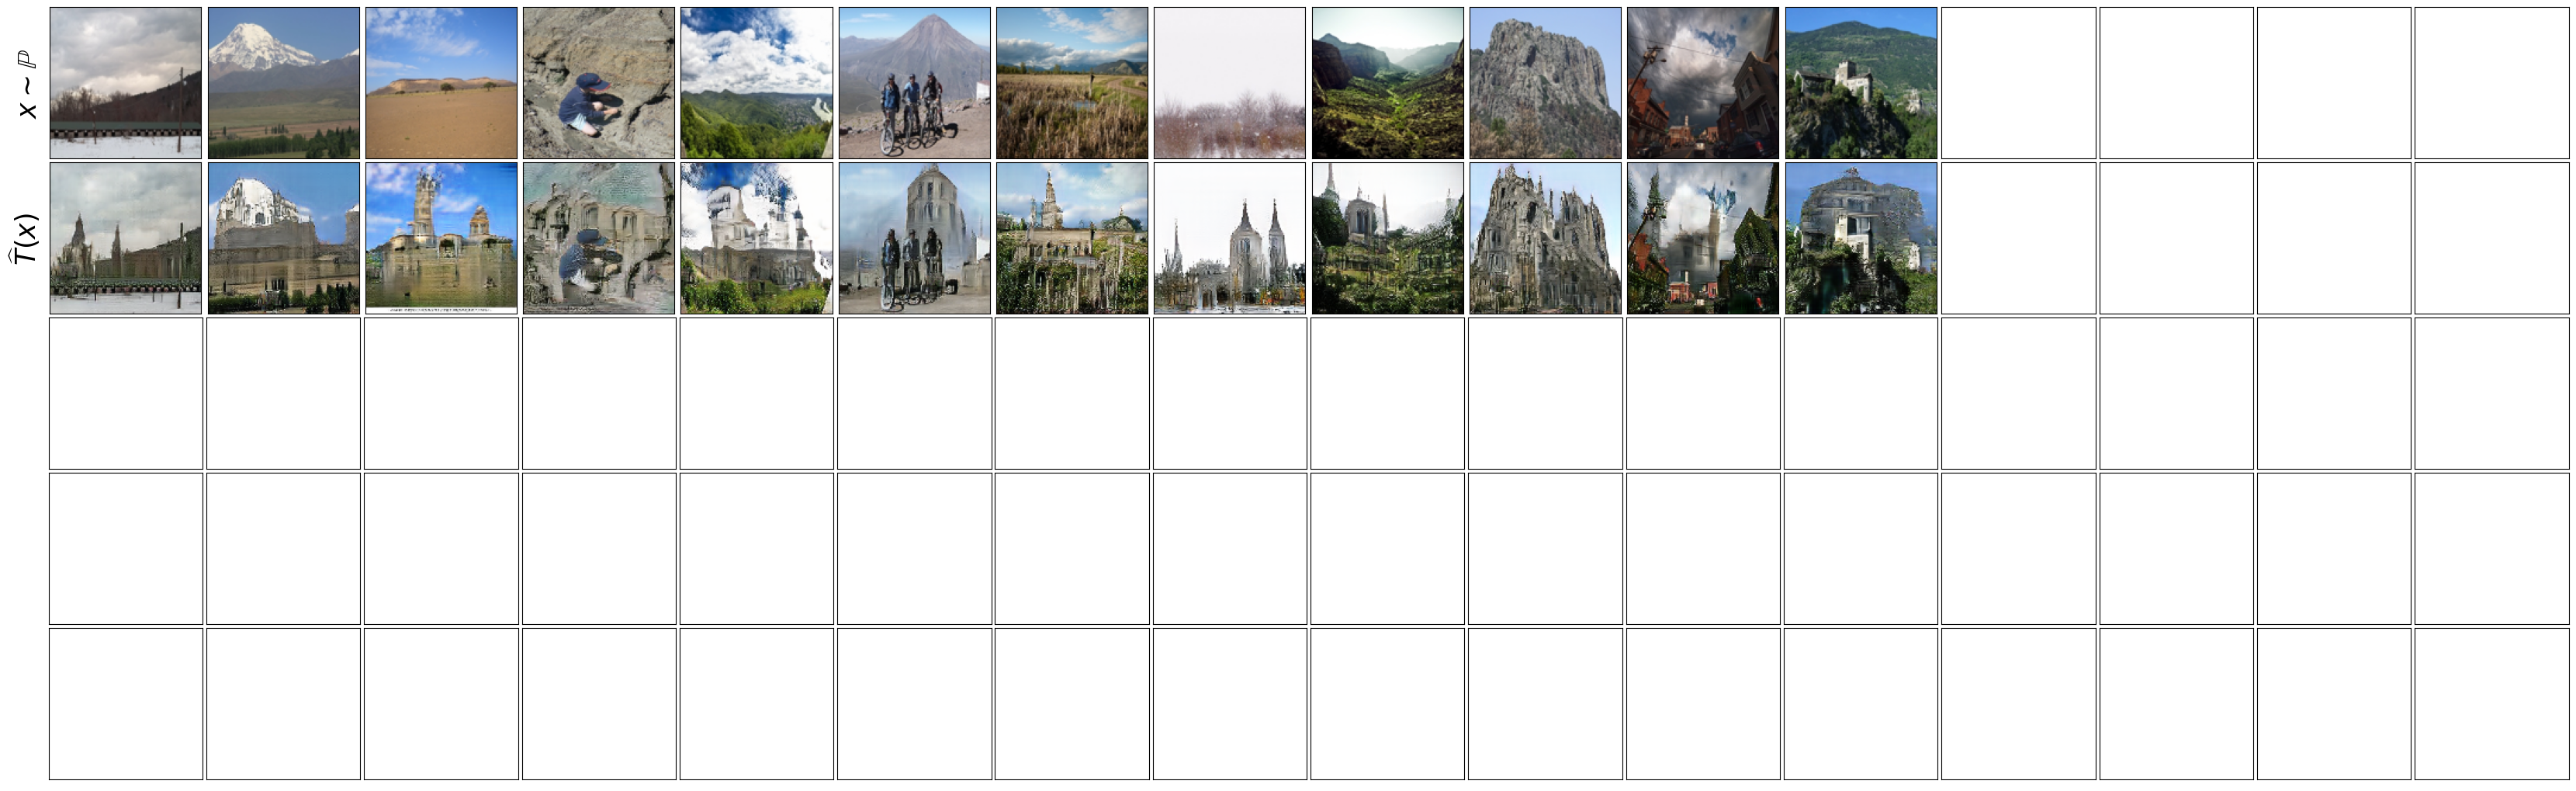

In [7]:
G_AB.eval()

AB_test = G_AB(X_test_fixed).detach()

fake_Y_test_numpy = tensor2img(AB_test)
real_X_test_numpy = tensor2img(X_test_fixed)

fig, axes = plt.subplots(5, 16, figsize=(16*2+1,10), dpi=100)
X_tensor = real_X_test_numpy

for j in range(12):
    axes[0][j].imshow(X_tensor[j])
    axes[0][j].get_xaxis().set_visible(False)
    axes[0][j].set_yticks([])
    
    axes[1][j].imshow(fake_Y_test_numpy[j])
    axes[1][j].get_xaxis().set_visible(False)
    axes[1][j].set_yticks([])
        
axes[0, 0].set_ylabel(r'$x\sim\mathbb{P}$', fontsize=25)
title = '\widehat{T}(x)'
axes[1, 0].set_ylabel(r'${}$'.format(title), fontsize=25) 

for i, ax in enumerate(axes.flatten()):
    ax.get_xaxis().set_visible(False)
    ax.set_yticks([])
    
fig.tight_layout(pad=0.001)    
plt.savefig("cycle_no_l1_outdoors2church_test.png")